In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [2]:
arteries = ["1-aortic_arch_I", "2-brachiocephalic_trunk", "3-subclavian_R_I", "4-subclavian_R_II",
            "5-radial_R", "6-ulnar_R_I", "7-ulnar_R_II", "8-common_interosseous_R", "9-vertebral_R",
            "10-common_carotid_R", "11-external_carotid_R", "12-internal_carotid_R", "13-aortic_arch_II",
            "14-common_carotid_L", "15-internal_carotid_L", "16-external_carotid_L", "17-aortic_arch_III",
            "18-subclavian_L_I", "19-vertebral_L", "20a-subclavian_L_II", "20b-axillary_L", "21-radial_L",
            "22-ulnar_L_I", "23-ulnar_L_II", "24-common_interosseous_L", "25-aortic_arch_IV",
            "26-posterior_intercostal_T6_R", "27-thoracic_aorta_II", "28-posterior_intercostal_T6_L",
            "29-thoracic_aorta_III", "30-posterior_intercostal_T7_R", "31-thoracic_aorta_IV",
            "32-posterior_intercostal_T7_L", "33-thoracic_aorta_V", "34-celiac_trunk", "35-common_hepatic",
            "36-splenic_I", "37-splenic_II", "38-left_gastric", "39-abdominal_aorta_I", "40-superior_mesenteric",
            "41-abdominal_aorta_II", "42-renal_L", "43-abdominal_aorta_III", "44-renal_R",
            "45-abdominal_aorta_IV", "46-inferior_mesenteric", "47-abdominal_aorta_V", "48-common_iliac_R",
            "49-internal_iliac_R", "50-external_iliac_R", "51-profunda_femoris_R", "52-femoral_R_II",
            "53-popliteal_R_II", "54-anterior_tibial_R", "55-common_iliac_L", "56-internal_iliac_L",
            "57-external_iliac_L", "58-profunda_femoris_L", "59-femoral_L_II", "60-popliteal_L_II",
            "61-anterior_tibial_L", "62-basilar", "63-posterior_cerebral_P1_L", "64-posterior_cerebral_P2_L",
            "65-posterior_communicating_L", "66-internal_carotid_II_L", "67-middle_cerebral_L",
            "68-anterior_cerebral_I_L", "69-anterior_cerebral_II_L", "70-anterior_communicating",
            "71-anterior_cerebral_II_R", "72-posterior_cerebral_P1_R", "73-posterior_cerebral_P2_R",
            "74-posterior_communicating_R", "75-internal_carotid_II_R", "76-middle_cerebral_R",
            "77-anterior_cerebral_I_R"]

In [3]:
def read_waves(f):
    w = np.loadtxt(f)
    return w[:,1:]

In [4]:
def check_ends(w, tol):
    if np.abs(w[0,2] - w[-1,2]) < tol:
        return True
    else:
        return False

In [5]:
def reflection_coeff(Adp, Ad1, Ad2, cdp, cd1, cd2, rho):
    inv_rho = 1./(1060.*rho)
    Yabd = Adp*inv_rho/cdp
    Yil1 = Ad1*inv_rho/cd1
    Yil2 = Ad2*inv_rho/cd2

    n = Yabd - Yil1 - Yil2
    d = Yabd + Yil1 + Yil2

    return n/d

In [6]:
def reflection_coeff(Adp, Ad1, Ad2, cdp, cd1, cd2, rho):
    inv_rho = 1./rho
    Yabd = Adp*inv_rho/cdp
    Yil1 = Ad1*inv_rho/cd1
    Yil2 = Ad2*inv_rho/cd2

    n = Yabd - Yil1 - Yil2
    d = Yabd + Yil1 + Yil2

    return n/d

In [7]:
def get_rho(case):
    with open("../data/{0}/{0}.yml".format(case), 'r') as f:
        data = load(f, Loader=Loader)
        return data["blood"]["rho"]

In [8]:
def check_case(folder, case):
    try:
        w_aorta_P = np.loadtxt("{0}/{1}_P.last".format(folder, arteries[12]))[:,3]
        w_brachial_P = np.loadtxt("{0}/{1}_P.last".format(folder, arteries[3]))[:,3]

        w_abdominal_A = np.loadtxt("{0}/{1}_A.last".format(folder, arteries[47]))[:,3]
        w_iliac1_A = np.loadtxt("{0}/{1}_A.last".format(folder, arteries[48]))[:,3]
        w_iliac2_A = np.loadtxt("{0}/{1}_A.last".format(folder, arteries[55]))[:,3]

        w_abdominal_c = np.loadtxt("{0}/{1}_c.last".format(folder, arteries[47]))[:,3]
        w_iliac1_c = np.loadtxt("{0}/{1}_c.last".format(folder, arteries[48]))[:,3]
        w_iliac2_c = np.loadtxt("{0}/{1}_c.last".format(folder, arteries[55]))[:,3]
    except:
        return [0, 0, 0, 0]
    
    DBP = np.min(w_brachial_P)/133.332
    SBP = np.max(w_brachial_P)/133.332
    BPP = SBP - DBP
    MBP = np.mean(w_brachial_P)/133.332

    Adp = np.min(w_abdominal_A)
    Ad1 = np.min(w_iliac1_A)
    Ad2 = np.min(w_iliac2_A)

    cdp = np.min(w_abdominal_c)
    cd1 = np.min(w_iliac1_c)
    cd2 = np.min(w_iliac2_c)
    
    rho = get_rho(case)
    
    Rf = reflection_coeff(Adp, Ad1, Ad2, cdp, cd1, cd2, rho)
    
    if DBP < 40 or SBP > 200 or BPP < 25 or BPP > 100 or np.abs(Rf) > 0.3:
        return [0, 0, 0, 0]
    else:
        return [DBP, SBP, BPP, Rf]

In [31]:
M = []
D = []
# N = 100
N = 10
case = 0
count = 0
time = np.linspace(0,1,100)
for n in range(N):
    for age in range(20, 81):
        case += 1
        folder = "../data/{0}/adan_results".format(case)
        checkout = check_case(folder, case)
        if checkout[0] == 0:
            continue
            
        D.append([case, age, checkout[0], checkout[1], checkout[2], checkout[3]])
        for artery in arteries:
            for q, tol, mul in zip(['P', 'u', 'Q'], [1.0, 1e-3, 1e-5], [1/133.332, 1.0, 1e6]):
                w = read_waves("{0}/{1}_{2}.last".format(folder, artery, q))
                    
                if q != 'u':
                    w *= mul

                if not check_ends(w, tol):
                    break
    
                for i in range(time.shape[0]):
                    M.append([case, age, artery, q, w[i,0], w[i,2], w[i,-1], time[i]])

            else:
                continue
        count += 1
print(count)

542


In [32]:
labels = ["Case", "Age", "DBP", "SBP", "BPP", "Rf"]
dist_df = pd.DataFrame(D, columns=labels)
dist_df.head()

,Case,Age,DBP,SBP,BPP,Rf
0,1,20,76.446468,107.244950,30.798483,-0.006672
1,3,22,75.975668,102.678118,26.702450,-0.007569
2,4,23,77.091107,106.975907,29.884800,-0.006102
3,5,24,74.212625,107.976999,33.764374,-0.007240
4,6,25,76.144226,108.042306,31.898080,-0.005273


In [34]:
labels = ["Case", "Age", "Artery", "q", "inlet", "midpoint", "outlet", "time"]
df = pd.DataFrame(M, columns=labels)
df.head()

,Case,Age,Artery,q,inlet,midpoint,outlet,time
0,1,20,1-aortic_arch_I,P,77.373566,77.359618,77.360043,0.000000
1,1,20,1-aortic_arch_I,P,77.105259,77.091441,77.091876,0.010101
2,1,20,1-aortic_arch_I,P,76.838681,76.824982,76.825407,0.020202
3,1,20,1-aortic_arch_I,P,78.526896,78.121099,77.455779,0.030303
4,1,20,1-aortic_arch_I,P,80.898167,80.454113,79.682537,0.040404


In [161]:
a = df.groupby(["Artery", "q", "Age", "time"]).agg(['mean', 'std'])[["inlet", "midpoint", "outlet"]]

In [162]:
a.head()

inlet             midpoint            \
                                     mean       std       mean       std   
Artery          q Age time                                                 
1-aortic_arch_I P 20  0.000000  74.421260  3.235339  74.413224  3.237713   
                      0.010101  74.148626  3.260060  74.140687  3.262377   
                      0.020202  73.878127  3.284278  73.870234  3.286565   
                      0.030303  75.549342  3.079908  75.157329  3.098759   
                      0.040404  77.837139  2.801581  77.422393  2.815556   

                                   outlet            
                                     mean       std  
Artery          q Age time                           
1-aortic_arch_I P 20  0.000000  74.407043  3.237290  
                      0.010101  74.134565  3.261940  
                      0.020202  73.864125  3.286130  
                      0.030303  74.604688  3.159263  
                      0.040404  76.802783  2.871421

In [163]:
b = a.reset_index()
b.columns = ["Artery", "q", "Age", "time",
             "inlet_mean", "inlet_std",
            "mid_mean", "mid_std",
            "outlet_mean", "outlet_std"]

In [164]:
b.head()

,Artery,q,Age,time,inlet_mean,inlet_std,mid_mean,mid_std,outlet_mean,outlet_std
0,1-aortic_arch_I,P,20,0.000000,74.421260,3.235339,74.413224,3.237713,74.407043,3.237290
1,1-aortic_arch_I,P,20,0.010101,74.148626,3.260060,74.140687,3.262377,74.134565,3.261940
2,1-aortic_arch_I,P,20,0.020202,73.878127,3.284278,73.870234,3.286565,73.864125,3.286130
3,1-aortic_arch_I,P,20,0.030303,75.549342,3.079908,75.157329,3.098759,74.604688,3.159263
4,1-aortic_arch_I,P,20,0.040404,77.837139,2.801581,77.422393,2.815556,76.802783,2.871421


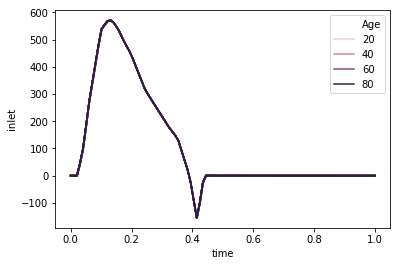

In [175]:
ax =sns.lineplot(x="time", y="inlet", hue="Age",
                 data=df.loc[df["q"] == "Q"].loc[df["Artery"] == arteries[0]],
                 ci="sd")

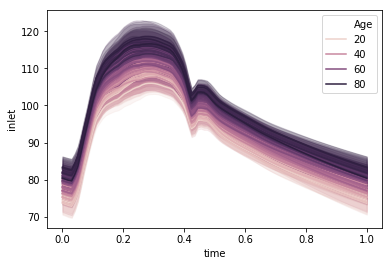

In [43]:
ax =sns.lineplot(x="time", y="inlet", hue="Age",
                 data=df[(df["q"] == "P") & (df["Artery"] == "3-subclavian_R_I")],
                 ci="sd")

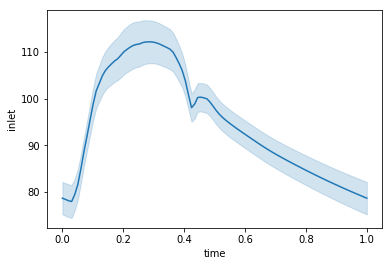

In [48]:
sns.lineplot(x="time", y="inlet", data=df.loc[df["q"] == "P"].loc[df["Artery"] == "3-subclavian_R_I"], ci="sd")

In [15]:
# df.to_hdf("a.h5", key="df")

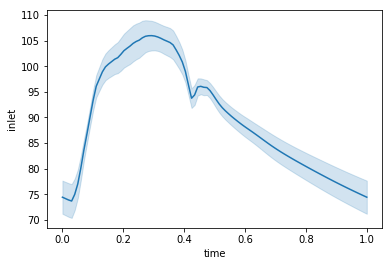

In [36]:
a21 = df.loc[df["q"] == "P"].loc[df["Age"] == 20].loc[df["Artery"] == "3-subclavian_R_I"]
sns.lineplot(x="time", y="inlet", data=a21, ci="sd")

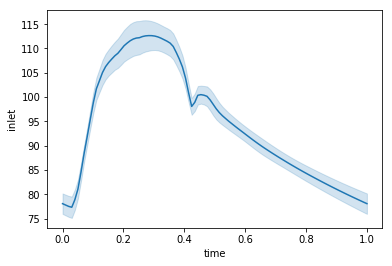

In [37]:
a21 = df.loc[df["q"] == "P"].loc[df["Age"] == 50].loc[df["Artery"] == "3-subclavian_R_I"]
sns.lineplot(x="time", y="inlet", data=a21, ci="sd")

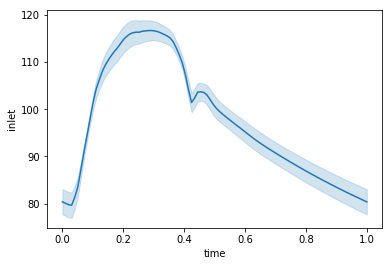

In [38]:
a21 = df.loc[df["q"] == "P"].loc[df["Age"] == 80].loc[df["Artery"] == "3-subclavian_R_I"]
sns.lineplot(x="time", y="inlet", data=a21, ci="sd")